<a href="https://colab.research.google.com/github/Jojo666/PKNP-Data/blob/master/1SVM_GEEFeatureclass_pknp_L8T1withBigGamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mapping the forest types of Cambodia using remote sensing (RS) and machine learning (ML)**


**Google Earth Engine** 
is a cloud based geospatial analysis platform that enables users to visualize and analyze satellite images of our planet. Scientists and non-profits use Earth Engine for remote sensing research, predicting disease outbreaks, natural resource management, and more. Has a multi-petabyte catalog of RS data

**Google Colab** is a free **Jupyter Python notebook environment** that runs entirely in the cloud. Most importantly, it does not require a setup and the notebooks that you create can be simultaneously edited by your team members - just the way you edit documents in Google Docs. Colab supports many popular machine learning libraries which can be easily loaded in your notebook.

In [1]:
#!pip install geemap

!pip install geemap


#geemap is a Python package for interactive mapping with Google Earth Engine (GEE),

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Connect the Google colab Python environment to Google Earth Engine (GEE)

In [2]:
#@title Connect the Google colab Python environment to Google Earth Engine (GEE)


import ee #enable connection to GEE

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=sHKWRUbtPmJHLuxOGQHrsw_CiaOFiazI8xQHoBrzkx4&tc=RVr69TTZh5vX5kCit87JeBSGJsNIKRBX3vW6hWfhTpg&cc=NukdRyh1BYsJ23ycz9QmF_SMs9QxkGeR_7-1yip7gA8

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgdQJZ0MQ2G1KFV2kLwIfGfM39dHGqaWqi8X0naj1gQGOKoQQNcOT0

Successfully saved authorization token.


In [5]:
import ee #Earth Engine Python library
import geemap


In [6]:
#Map = geemap.Map(center=[-16.6,-62.931458], zoom=6)
#Map

Map = geemap.Map(center=[13.5,104.16], zoom=7)

Map


Map(center=[13.5, 104.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

Get the country outline for Cambodia #Bolivia

In [7]:
#aoi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Bolivia'))

##An object defining a layer of features whose geometry and attributes will be stored directly within the web map. 
##

aoi=ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_co', 'CB'))


In [8]:
#@title Cambodia outline

Map.addLayer(aoi, {}, 'Camabodia')
Map

Map(bottom=15444.0, center=[13.5, 104.16], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

Access Landsat data via Earth Engine (using the package ee)

In [9]:
# Add Earth Engine dataset
# Input imagery is a cloud-free Landsat 8 composite.
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2_SR?hl=en#bands
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filterDate('2019-01-01', '2019-12-31')
#l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterDate('2019-01-01', '2019-12-31')
#l8=ee.ImageCollection('LANDSAT/LC08/C01/T2_SR').filterDate('2019-01-01', '2019-12-31')

#Image Collection is a GEE data type-stores multi-band multiple Landsat images

In [10]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11']

#Atmospheric correction (TOA) 
#image=ee.Algorithms.Landsat.simpleComposite(**{'collection':l8.filterDate('2018-01-01', '2018-12-31'),'asFloat': True})

#clip Landsat data to the extent of Bolivia and just select the specific bands
#image = image.clip(aoi).select(bands) 

image=l8.median().clip(aoi).select(bands)





In [ ]:
#@title Add topographic data (obtained via GEE)

dataset = ee.Image('USGS/SRTMGL1_003') #SRTM (Shuttle Radar Topography Mission) Topographic data

elevation = dataset.select('elevation').clip(aoi)

slope = ee.Terrain.slope(elevation).clip(aoi)

fused = image.addBands(slope)

bandNames = fused.bandNames() 

print('Band names: '+str(bandNames.getInfo()))


Band names: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'slope']


In [11]:
train = ee.FeatureCollection('users/minervas_jojo_code/train1').remap([1, 2,3,4,5,6,7], [0,1,2,3,4,5,6], 'class');
#https://code.earthengine.google.com/?asset=users/minervas_jojo_code/train1 

test = ee.FeatureCollection('users/minervas_jojo_code/test1').remap([1, 2,3,4,5,6,7], [0,1,2,3,4,5,6], 'class');
#https://code.earthengine.google.com/?asset=users/minervas_jojo_code/test1

points = train.merge(test)#.aside(print,'all points')#.getInfo(); 

In [12]:
Map.addLayer(points,{},'Points')

In [13]:
# This property of the table stores the land cover labels.
label = 'class'

In [14]:
data = image.select(bands).sampleRegions(collection=points,properties=[label],
                                         scale=30)
                                                       

In [15]:
data.aggregate_stats(label).getInfo()

{'max': 6,
 'mean': 3.0547550432276656,
 'min': 0,
 'sample_sd': 2.0057429498475674,
 'sample_var': 4.023004780863221,
 'sum': 1060,
 'sum_sq': 4630,
 'total_count': 347,
 'total_sd': 2.002850745098884,
 'total_var': 4.011411107143155,
 'valid_count': 347,
 'weight_sum': 347,
 'weighted_sum': 1060}

In [16]:
data = data.randomColumn(seed=0)
split_thresh = 0.8

train = data.filter(ee.Filter.lt('random',split_thresh))
test = data.filter(ee.Filter.gte('random',split_thresh))

In [17]:
classifier=ee.Classifier.libsvm(**{
    'kernelType':'RBF',
    'gamma':20,#0.5,####################### BIG GAMMA to get best prediction accuracy ! ############################################
    'cost':10
})

In [18]:
#init_params = {"numberOfTrees":100, # the number of individual decision tree models
            #  "variablesPerSplit":None,  # the number of features to use per split
             # "minLeafPopulation":1, # smallest sample size possible per leaf
             # "bagFraction":0.5, # fraction of data to include for each individual tree model
             # "maxNodes":None, # max number of leafs/nodes per tree
              # "seed":0}  # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters


clf = classifier.train(train, label, bands)

In [19]:
classified=image.classify(clf)

In [ ]:
#Map.addLayer(classified,{'min': 0, 'max': 6, 'palette': ['red', 'blue','green','pink']})

In [20]:

#legend_keys = ['0', '1', '2', '3','4', '5', '6']
legend_keys = ['Cashew', 'Cassava_bare', 'Regen_less_10', 'Regen_10orMore','Selective_Logging', 'Nearty Intact', 'Degraded']
# 6 7 Degraded
# 5 6 Nearty Intact
# 4 5 Selective_Logging
# 3 4 Regen_10orMore
# 2 3 Regen_less_10
# 1 2 Cassava_bare
# 0 1 Cashew
legend_colors =['#ADB3AE', '#F0AC01', '#0C9300', '#F4FE00','#00F8FE', '#FFA06D', '#D65E00']

Map.addLayer(classified,{'min': 0, 'max': 6, 'palette': legend_colors})
Map.add_legend(
    legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright'
)
Map

Map(bottom=15444.0, center=[13.5, 104.16], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [21]:
import pandas as pd
import numpy as np

In [22]:
ConfMatrix=clf.confusionMatrix()#.getInfo()
trainResults = clf.confusionMatrix().getInfo()
trainCM = pd.DataFrame(np.asarray(trainResults))

In [23]:
print('Train Sum')
print(trainCM.sum(axis=1))

Train Sum
0    47
1    17
2    39
3    56
4    30
5    52
6    39
dtype: int64


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

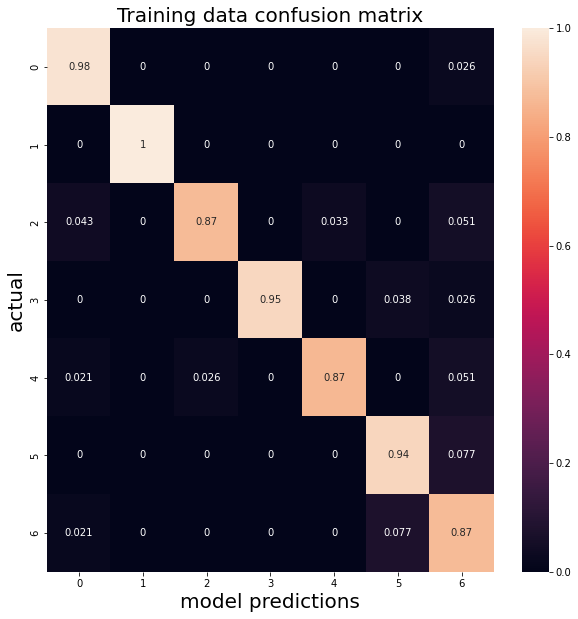

In [25]:
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM/trainCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Training data confusion matrix", fontsize=20);

In [26]:
testing = image.select(bands).sampleRegions(**{
  'collection': test,
  'properties': [label],
  'scale': 30
})

In [27]:
# Train a CART classifier with default parameters.
tested = classifier.train(test, label, bands)

In [28]:
testResults = tested.confusionMatrix().getInfo()
testCM = pd.DataFrame(np.asarray(testResults))

In [29]:
testCM

,0,1,2,3,4,5,6
0,12,0,0,0,0,0,0
1,0,9,0,0,0,0,0
2,0,0,14,0,0,0,0
3,0,0,0,7,0,0,0
4,0,0,0,0,8,0,0
5,0,0,0,0,0,9,0
6,0,0,0,0,0,0,8


In [ ]:
#overall accuracy, kappa coefficient ...

In [30]:
# Calculate overall accuracy.
OverallAccuracy=ConfMatrix.accuracy().getInfo()
print("Overall accuracy", OverallAccuracy);

# Calculate consumer's accuracy, also known as user's accuracy or
# specificity and the complement of commission error (1 − commission error).
ConsumersAccuracy=ConfMatrix.consumersAccuracy().getInfo()
print("Consumer's accuracy", ConsumersAccuracy);

# Calculate producer's accuracy, also known as sensitivity and the
# compliment of omission error (1 − omission error).
ProducersAccuracy=ConfMatrix.producersAccuracy().getInfo()
print("Producer's accuracy", ProducersAccuracy);

# Calculate kappa statistic.
KappaStatistic=ConfMatrix.kappa().getInfo()
print('Kappa statistic', KappaStatistic);

Overall accuracy 0.925
Consumer's accuracy [[0.92, 1, 0.9714285714285714, 1, 0.9629629629629629, 0.8909090909090909, 0.7906976744186046]]
Producer's accuracy [[0.9787234042553191], [1], [0.8717948717948718], [0.9464285714285714], [0.8666666666666667], [0.9423076923076923], [0.8717948717948718]]
Kappa statistic 0.9110182957279702
